In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'ray_tracing_synthesis')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
torch.use_deterministic_algorithms(True)
import matplotlib.pyplot as plt
from model import build_net

from utils import remove_blind_region_psf0, remove_blind_region_psf7p5, remove_blind_region_minuspsf7p5,set_stateless_batchnorm

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import random
import time
from time import sleep
from PIL import Image

from ray_tracing_synthesis import SoSToTimeShiftTransformer, image_to_sos_map

PARAM_SOS_BEAMFORMING = 1540
PARAM_SCALING_INPUT = 100000000
PARAM_SCALING_OUTPUT = 100
PARAM_BASE_OUTPUT = PARAM_SOS_BEAMFORMING
PARAM_NUMBER_OF_TRAINING_DATA = 1280000
PARAM_LEARNING_RATE = 0.0005
PARAM_WEIGHTDECAY = 0.3
EPOCH_NUM = 3
BATCH_SIZE = 32
GPU_BASE = 4
GPU_LIST_TO_PARALLEL = [GPU_BASE, 1,2,3] ### Specify the available GPU indices in your machine 
STARTING_PIXEL = 19
WIDTH_IN_PIXEL = 50

from worker_module import preparing_training_data  


data_parent_dir = (
    './untar_ImageNet_6_1/'
)

def eval_testingdata(model, test_data, test_label, criterion):
    outputs = (
        model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
        [:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL] * PARAM_SCALING_OUTPUT
        + PARAM_BASE_OUTPUT
    )
    loss = criterion(outputs, test_label.to(f"cuda:{GPU_BASE}", dtype=torch.float))
    print("RMSE in testing set is", torch.sqrt(loss.cpu()).detach().numpy())



import multiprocessing as mp
mp.set_start_method("spawn", force=True)

# Prepare test data
transformer = SoSToTimeShiftTransformer()
sos_from_ImageNet = []
time_lag_from_ImageNet = []
for i in range(PARAM_NUMBER_OF_TRAINING_DATA+1, PARAM_NUMBER_OF_TRAINING_DATA+201):
    image = Image.open(f"{data_parent_dir}grayscale_cropped_{i}.JPEG")
    sos_map = image_to_sos_map(image)
    time_lag_from_ImageNet.append([
        remove_blind_region_psf7p5(transformer.transform(sos_map, "7p5psf")),
        remove_blind_region_psf0(transformer.transform(sos_map, "0psf")),
        remove_blind_region_minuspsf7p5(transformer.transform(sos_map, "minus7p5psf")),
    ])
    sos_from_ImageNet.append(sos_map[:, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL])

test_data = torch.tensor(np.array(time_lag_from_ImageNet))
test_label = torch.tensor(np.array(sos_from_ImageNet)).unsqueeze(1)
del sos_from_ImageNet, time_lag_from_ImageNet


Class initializing, device is cuda


In [2]:
def visualize_test_data():
    fig, axs = plt.subplots(2, 6, figsize=(16, 6))
    outputs_test = (
            model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
            [:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL] * PARAM_SCALING_OUTPUT
            + PARAM_BASE_OUTPUT
        ).cpu().detach().numpy()

    for i in range(2):
        for j in range(6):
            # Example: Plot a sine wave with a different phase in each subplot
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + (i * 4 + j))
            if i == 0:
                im = axs[i, j].imshow(test_label[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Ground Truth")
            if i == 1:
                im = axs[i, j].imshow(outputs_test[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Reconstructed")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            cbar = fig.colorbar(im, ax=axs[i, j])
            cbar.set_label("SoS [m/s]",fontsize = 13)

    plt.tight_layout()
    plt.show()

In [4]:
import pytorch_ssim

In [5]:
SSIM_LOSS = pytorch_ssim.SSIM()


Elapsed time = 15.663954019546509
batch 1 / 40000
running_loss = 4903.446044921875
batch_loss = 4457.66259765625
queue length = 3806
RMSE in testing set is 62.214493


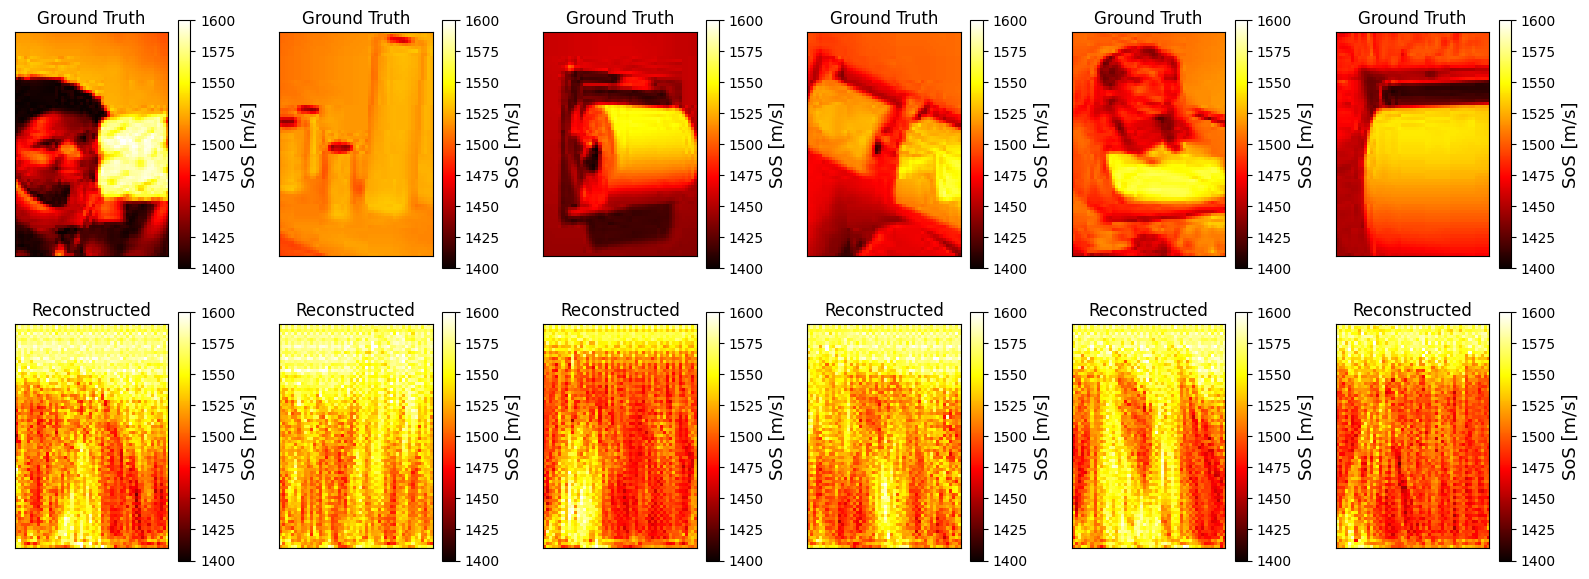

Elapsed time = 71.74167561531067
batch 1001 / 40000
running_loss = 1416.1656068356451
batch_loss = 1351.8170166015625
queue length = 96
RMSE in testing set is 30.041592
Elapsed time = 78.38110661506653
batch 2001 / 40000
running_loss = 1210.6784127737496
batch_loss = 840.677490234375
queue length = 46
RMSE in testing set is 24.25519
Elapsed time = 80.1428017616272
batch 3001 / 40000
running_loss = 1091.5203933055047
batch_loss = 716.4554443359375
queue length = 356
RMSE in testing set is 22.799637
Elapsed time = 77.94465446472168
batch 4001 / 40000
running_loss = 1011.2345220974718
batch_loss = 781.2081909179688
queue length = 36
RMSE in testing set is 22.770561
Elapsed time = 79.71891760826111
batch 5001 / 40000
running_loss = 950.128886372697
batch_loss = 636.0216674804688
queue length = 376
RMSE in testing set is 20.042892


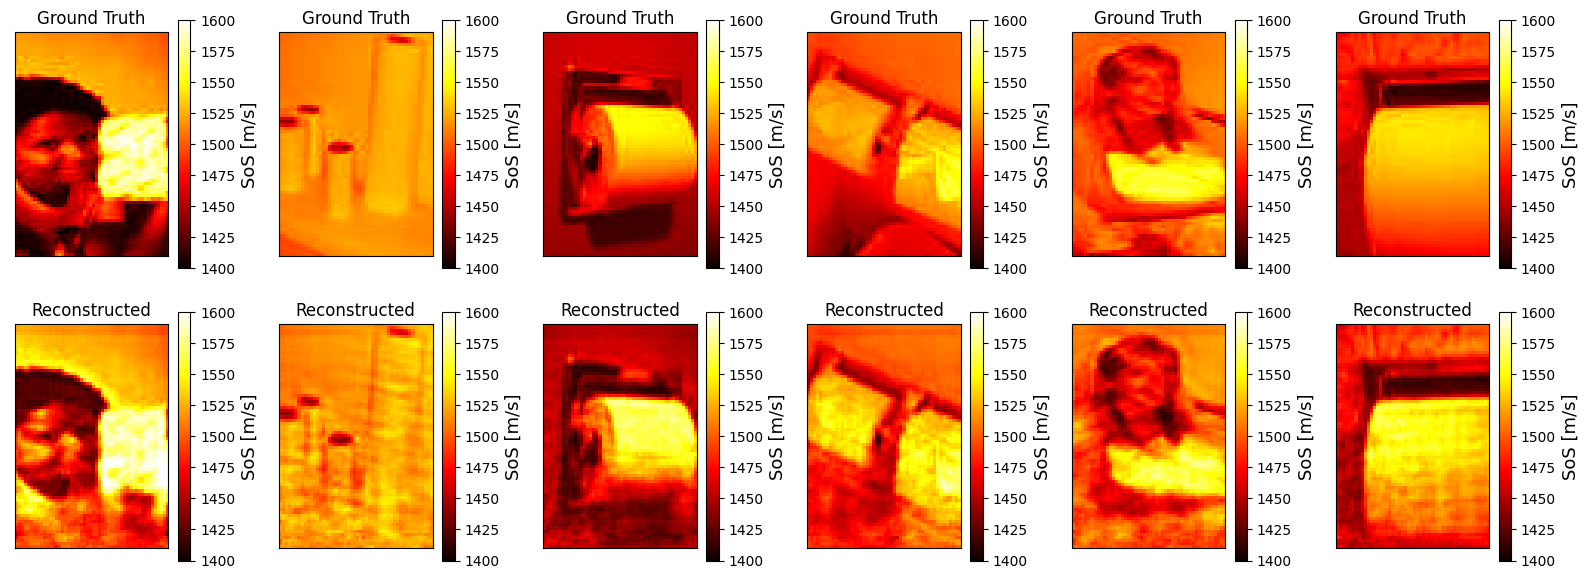

Elapsed time = 78.45494198799133
batch 6001 / 40000
running_loss = 900.8273134825827
batch_loss = 606.910400390625
queue length = 86
RMSE in testing set is 20.279652
Elapsed time = 77.79768323898315
batch 7001 / 40000
running_loss = 861.7771568134899
batch_loss = 579.7564697265625
queue length = 66
RMSE in testing set is 18.527994
Elapsed time = 79.64411973953247
batch 8001 / 40000
running_loss = 828.2339267935702
batch_loss = 518.8177490234375
queue length = 376
RMSE in testing set is 18.233347
Elapsed time = 78.62570571899414
batch 9001 / 40000
running_loss = 799.836916855933
batch_loss = 568.4304809570312
queue length = 86
RMSE in testing set is 17.957018
Elapsed time = 79.65794825553894
batch 10001 / 40000
running_loss = 774.9728084809063
batch_loss = 507.4630126953125
queue length = 186
RMSE in testing set is 17.916147


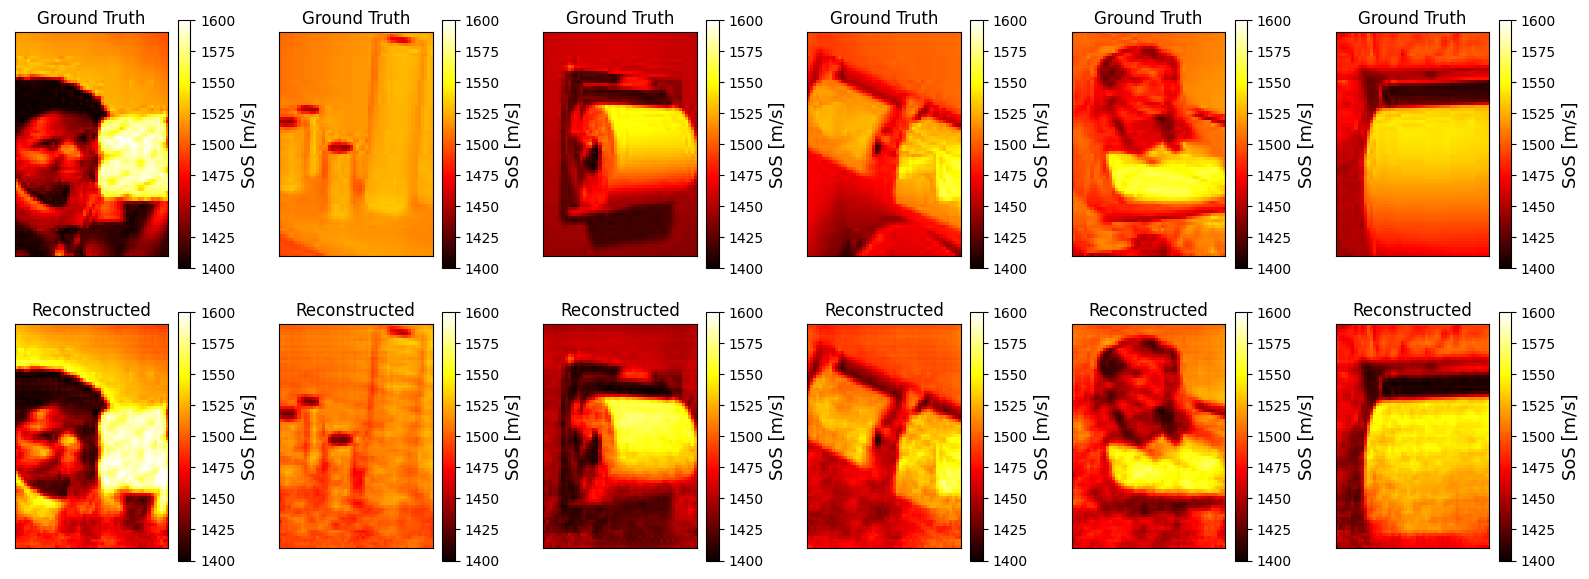

Elapsed time = 77.22491312026978
batch 11001 / 40000
running_loss = 753.3128823934089
batch_loss = 540.4513549804688
queue length = 76
RMSE in testing set is 17.131311
Elapsed time = 80.57393002510071
batch 12001 / 40000
running_loss = 733.8357146265824
batch_loss = 500.3123474121094
queue length = 446
RMSE in testing set is 15.844881
Elapsed time = 78.59319424629211
batch 13001 / 40000
running_loss = 716.2772248131259
batch_loss = 489.80242919921875
queue length = 156
RMSE in testing set is 16.852165
Elapsed time = 79.84718942642212
batch 14001 / 40000
running_loss = 700.4818879939236
batch_loss = 497.9018859863281
queue length = 136
RMSE in testing set is 15.243052
Elapsed time = 80.0736255645752
batch 15001 / 40000
running_loss = 686.1544502501391
batch_loss = 503.3592529296875
queue length = 416
RMSE in testing set is 16.113302


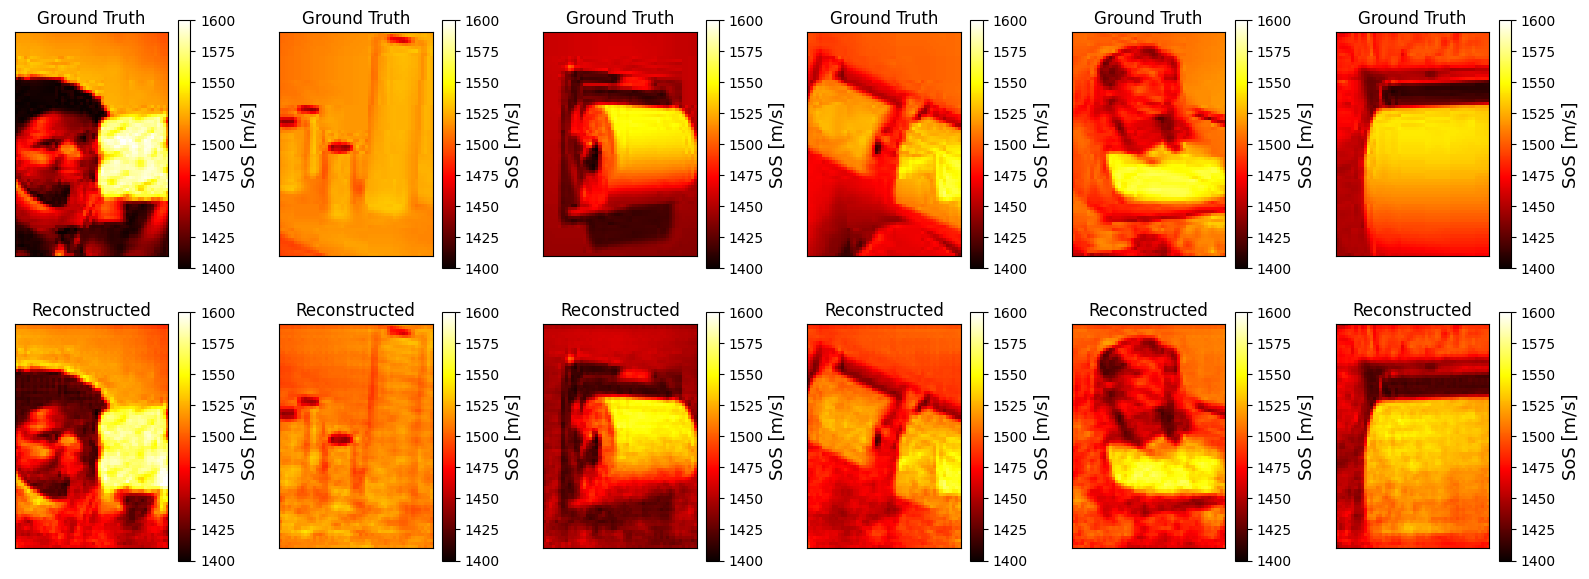

Elapsed time = 79.49893593788147
batch 16001 / 40000
running_loss = 672.919727937145
batch_loss = 435.25341796875
queue length = 246
RMSE in testing set is 15.412807
Elapsed time = 78.27442049980164
batch 17001 / 40000
running_loss = 660.9089367405104
batch_loss = 453.36700439453125
queue length = 136
RMSE in testing set is 16.240866
Elapsed time = 79.51858448982239
batch 18001 / 40000
running_loss = 649.9412383117777
batch_loss = 436.0098571777344
queue length = 206
RMSE in testing set is 16.72656
Elapsed time = 79.68420362472534
batch 19001 / 40000
running_loss = 639.8703915550136
batch_loss = 515.2011108398438
queue length = 246
RMSE in testing set is 15.473505
Elapsed time = 78.08208680152893
batch 20001 / 40000
running_loss = 630.2614393559423
batch_loss = 430.0395812988281
queue length = 376
RMSE in testing set is 16.523434


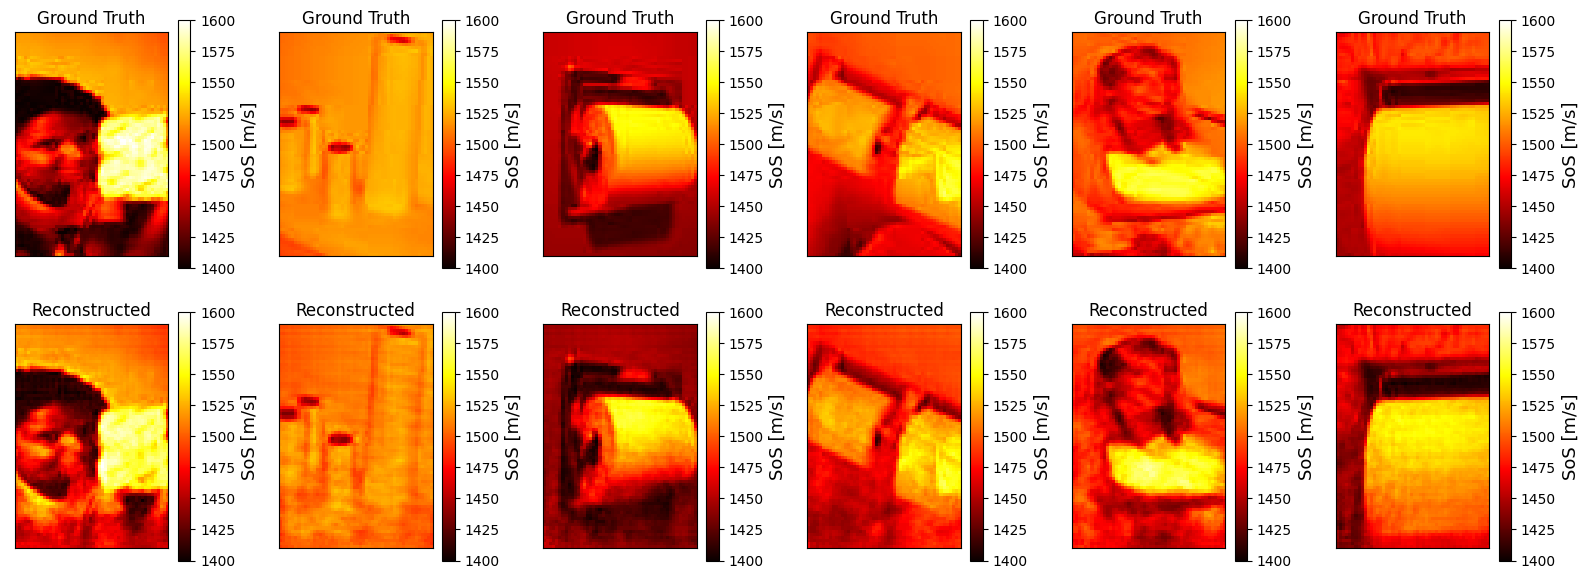

Elapsed time = 75.84598445892334
batch 21001 / 40000
running_loss = 621.4419661448259
batch_loss = 395.3525695800781
queue length = 236
RMSE in testing set is 13.994433
Elapsed time = 80.75991749763489
batch 22001 / 40000
running_loss = 613.2380740655768
batch_loss = 367.4400634765625
queue length = 306
RMSE in testing set is 14.14851
Elapsed time = 79.11899375915527
batch 23001 / 40000
running_loss = 605.54097836097
batch_loss = 417.8743896484375
queue length = 196
RMSE in testing set is 13.879932
Elapsed time = 78.87406301498413
batch 24001 / 40000
running_loss = 598.2219517086955
batch_loss = 412.1602783203125
queue length = 176
RMSE in testing set is 14.818645
Elapsed time = 79.17255139350891
batch 25001 / 40000
running_loss = 591.4079154942019
batch_loss = 432.3699951171875
queue length = 396
RMSE in testing set is 14.418963


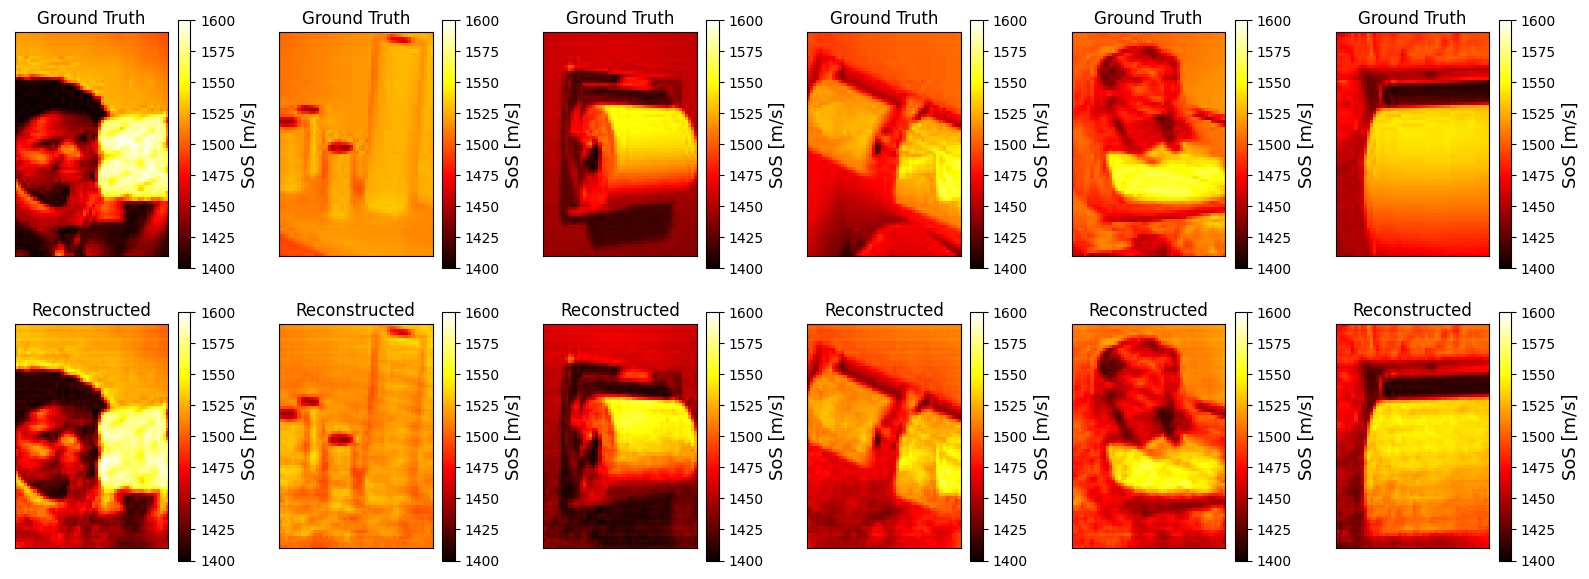

Elapsed time = 79.19655323028564
batch 26001 / 40000
running_loss = 585.0244064982437
batch_loss = 479.45550537109375
queue length = 316
RMSE in testing set is 13.851042
Elapsed time = 79.65930461883545
batch 27001 / 40000
running_loss = 578.9184483411656
batch_loss = 351.39654541015625
queue length = 356
RMSE in testing set is 14.649787
Elapsed time = 79.29847764968872
batch 28001 / 40000
running_loss = 573.1950030193678
batch_loss = 394.8521728515625
queue length = 36
RMSE in testing set is 14.335407
Elapsed time = 77.87207818031311
batch 29001 / 40000
running_loss = 567.6175844621168
batch_loss = 383.5665283203125
queue length = 46
RMSE in testing set is 14.560344
Elapsed time = 79.09033298492432
batch 30001 / 40000
running_loss = 562.4419550964669
batch_loss = 492.22393798828125
queue length = 206
RMSE in testing set is 14.237812


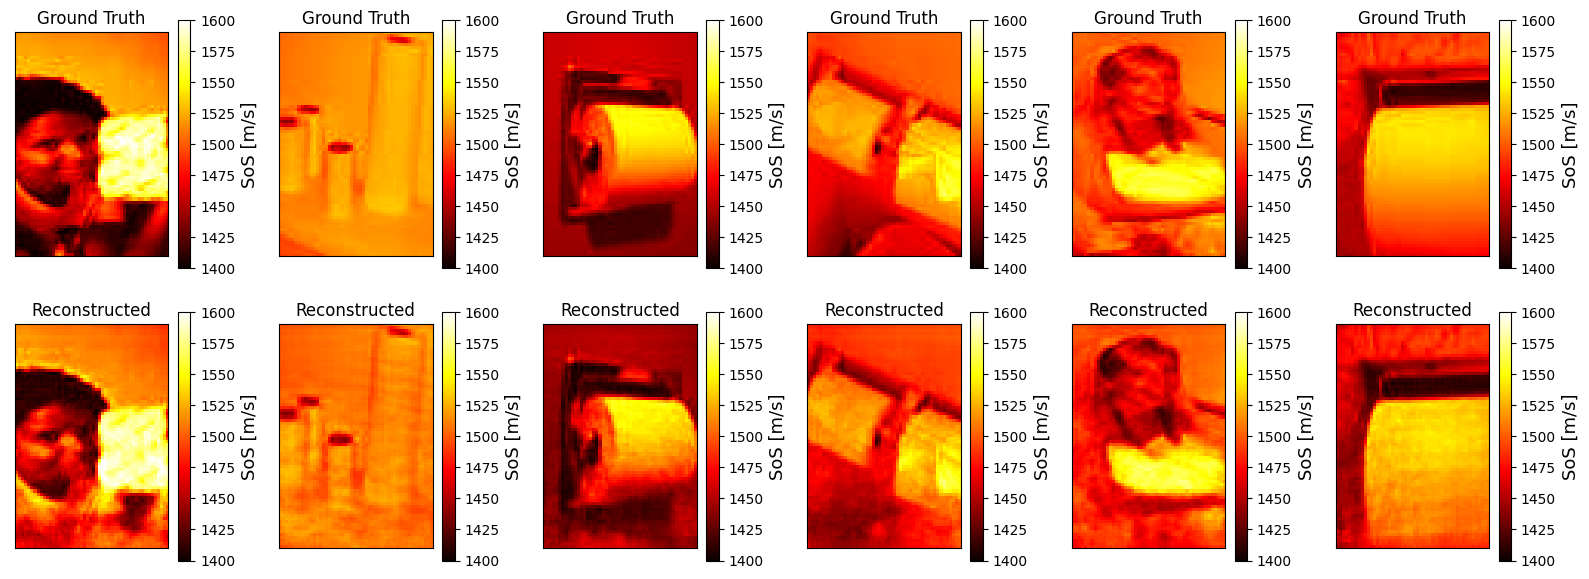

Elapsed time = 78.9360077381134
batch 31001 / 40000
running_loss = 557.3345439092135
batch_loss = 391.2380065917969
queue length = 186
RMSE in testing set is 15.008327
Elapsed time = 77.23175024986267
batch 32001 / 40000
running_loss = 552.6323039391795
batch_loss = 386.22979736328125
queue length = 166
RMSE in testing set is 13.245236
Elapsed time = 78.87753891944885
batch 33001 / 40000
running_loss = 548.1234970929644
batch_loss = 465.4824523925781
queue length = 206
RMSE in testing set is 13.501358
Elapsed time = 80.80691885948181
batch 34001 / 40000
running_loss = 543.8112113696394
batch_loss = 408.1961669921875
queue length = 396
RMSE in testing set is 13.415663
Elapsed time = 79.05581331253052
batch 35001 / 40000
running_loss = 539.63020182852
batch_loss = 393.2740783691406
queue length = 196
RMSE in testing set is 14.279208


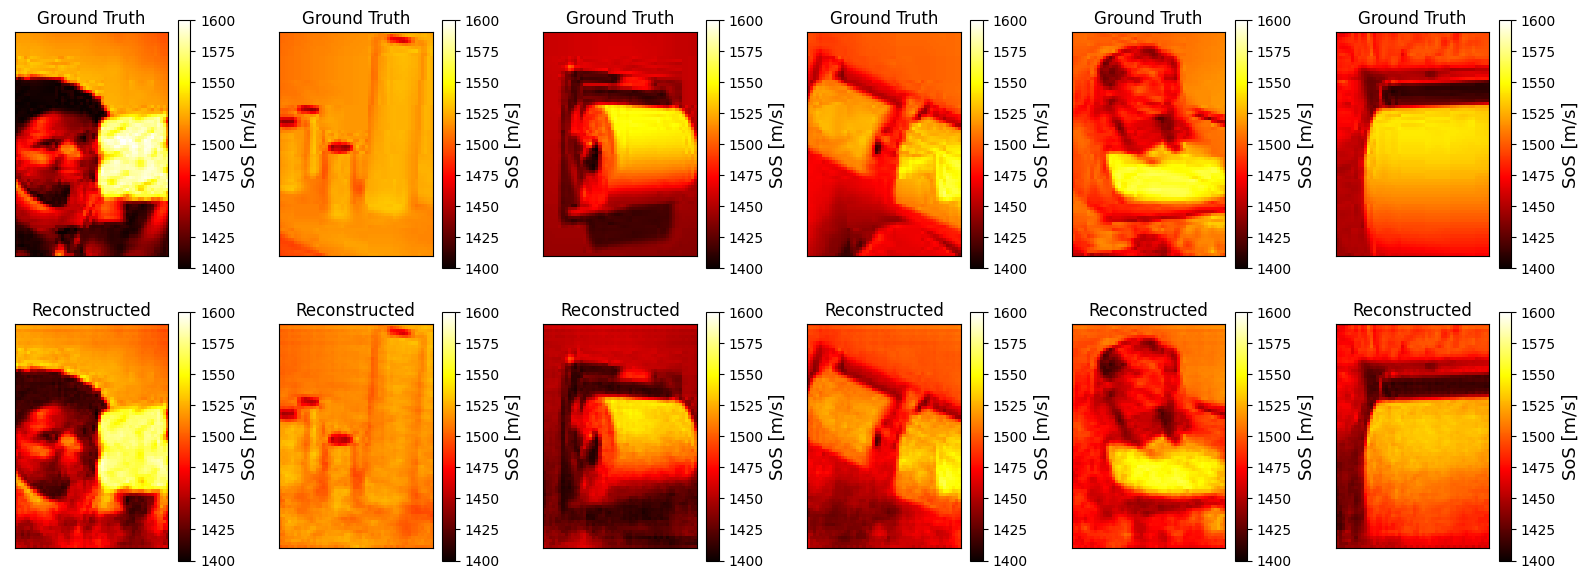

Elapsed time = 79.30594062805176
batch 36001 / 40000
running_loss = 535.6154670950559
batch_loss = 351.2054748535156
queue length = 476
RMSE in testing set is 13.235425
Elapsed time = 77.00584673881531
batch 37001 / 40000
running_loss = 531.8509643721288
batch_loss = 429.9889831542969
queue length = 246
RMSE in testing set is 13.31562
Elapsed time = 78.80283403396606
batch 38001 / 40000
running_loss = 528.2392569837505
batch_loss = 426.7908020019531
queue length = 76
RMSE in testing set is 14.672981
Elapsed time = 80.90227913856506
batch 39001 / 40000
running_loss = 524.6382079431811
batch_loss = 332.49859619140625
queue length = 386
RMSE in testing set is 12.196405
Epoch 1/3 finished. Average loss: 521.2363898399353
Elapsed time = 80.63256025314331
batch 1 / 40000
running_loss = 371.7135467529297
batch_loss = 375.9911804199219
queue length = 56
RMSE in testing set is 12.719134


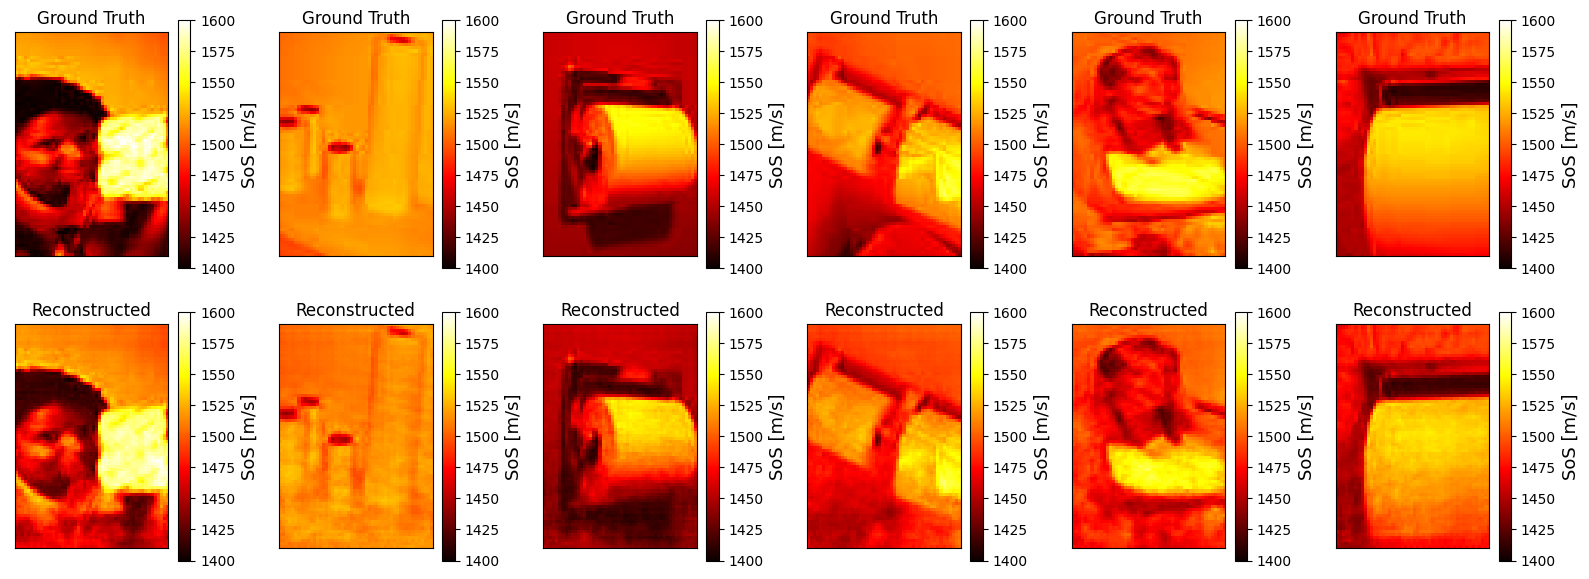

Elapsed time = 76.59548330307007
batch 1001 / 40000
running_loss = 383.4636328234644
batch_loss = 356.6033630371094
queue length = 96
RMSE in testing set is 13.215439
Elapsed time = 78.27337408065796
batch 2001 / 40000
running_loss = 384.4253672200602
batch_loss = 369.1518859863281
queue length = 496
RMSE in testing set is 12.903365
Elapsed time = 78.10633730888367
batch 3001 / 40000
running_loss = 383.4229333256182
batch_loss = 426.857421875
queue length = 356
RMSE in testing set is 13.981769
Elapsed time = 77.35402703285217
batch 4001 / 40000
running_loss = 383.06580101520285
batch_loss = 389.384033203125
queue length = 126
RMSE in testing set is 13.639265
Elapsed time = 80.75595808029175
batch 5001 / 40000
running_loss = 382.89889979066965
batch_loss = 414.59979248046875
queue length = 136
RMSE in testing set is 13.448764


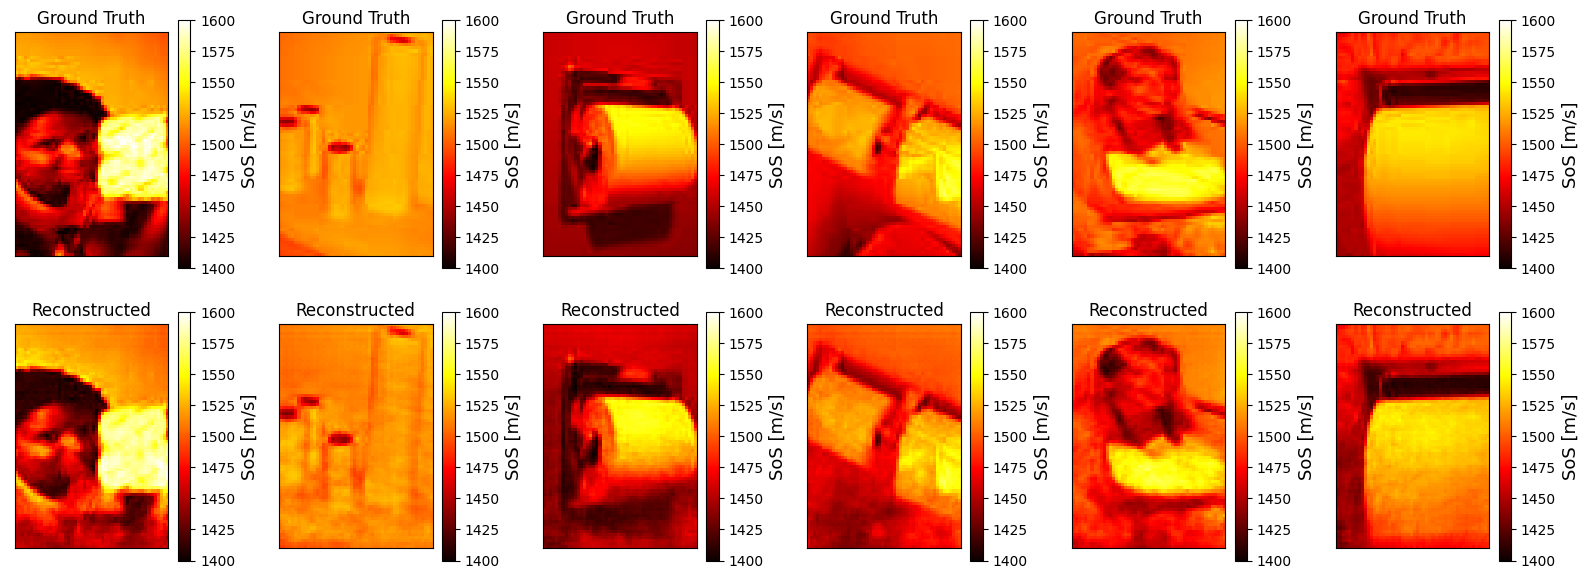

Elapsed time = 83.14428424835205
batch 6001 / 40000
running_loss = 382.4865459885767
batch_loss = 337.79644775390625
queue length = 266
RMSE in testing set is 12.577191
Elapsed time = 84.11603784561157
batch 7001 / 40000
running_loss = 381.70719484287275
batch_loss = 380.5933532714844
queue length = 246
RMSE in testing set is 13.682385
Elapsed time = 84.7689745426178
batch 8001 / 40000
running_loss = 381.06681949584015
batch_loss = 326.795166015625
queue length = 376
RMSE in testing set is 12.356168
Elapsed time = 81.45965361595154
batch 9001 / 40000
running_loss = 380.2903627312149
batch_loss = 373.2894592285156
queue length = 446
RMSE in testing set is 12.508121
Elapsed time = 81.79647278785706
batch 10001 / 40000
running_loss = 379.4676061735895
batch_loss = 459.24761962890625
queue length = 366
RMSE in testing set is 12.87662


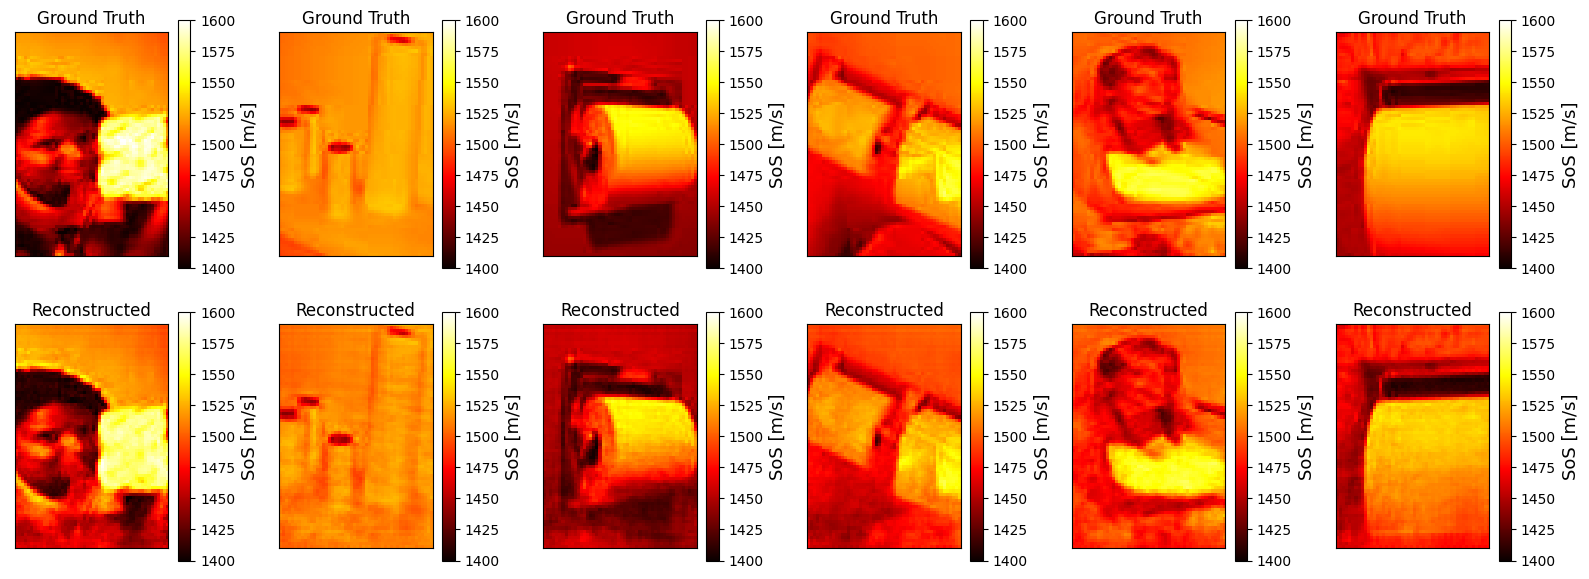

Elapsed time = 81.77532291412354
batch 11001 / 40000
running_loss = 378.6371830598893
batch_loss = 384.5642395019531
queue length = 166
RMSE in testing set is 14.00938
Elapsed time = 80.38272261619568
batch 12001 / 40000
running_loss = 378.1085681962959
batch_loss = 367.3061828613281
queue length = 236
RMSE in testing set is 13.538208
Elapsed time = 83.16665601730347
batch 13001 / 40000
running_loss = 377.2373516562168
batch_loss = 384.93475341796875
queue length = 336
RMSE in testing set is 13.53327
Elapsed time = 82.20661735534668
batch 14001 / 40000
running_loss = 376.6486836871902
batch_loss = 354.9461669921875
queue length = 46
RMSE in testing set is 12.19708
Elapsed time = 80.92102432250977
batch 15001 / 40000
running_loss = 376.0700508364835
batch_loss = 345.0065002441406
queue length = 176
RMSE in testing set is 12.300078


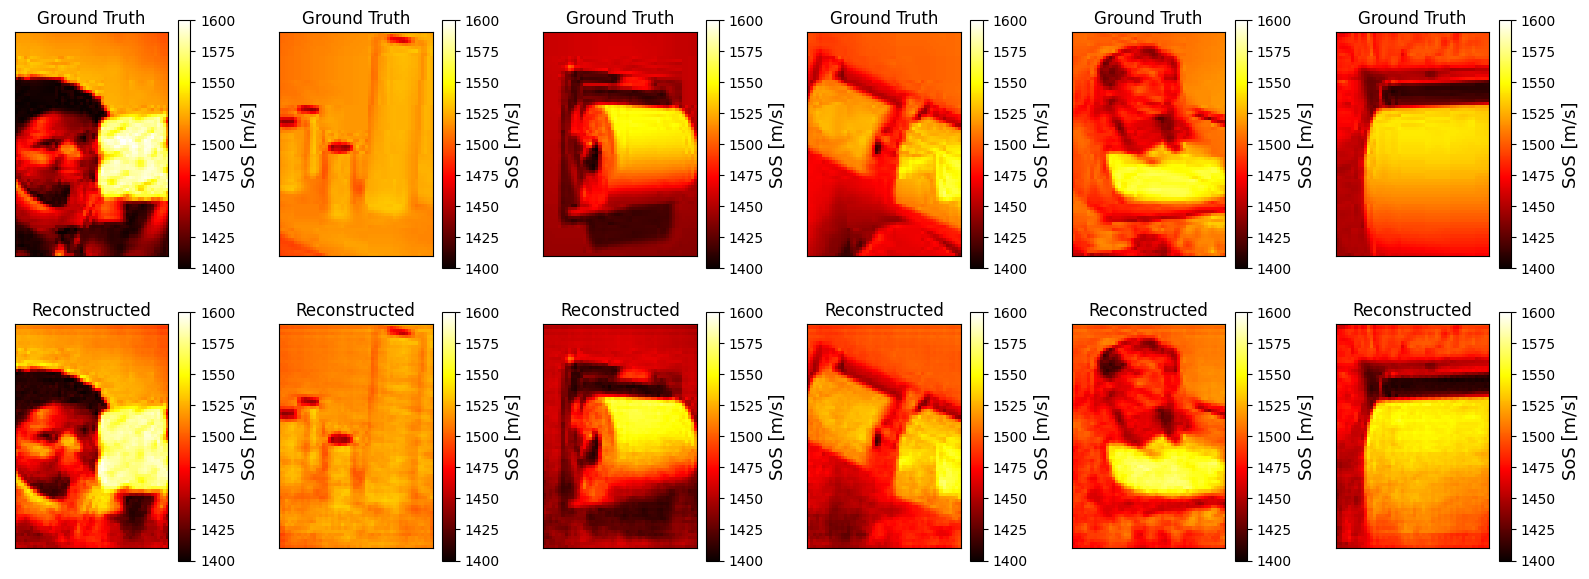

Elapsed time = 81.14349794387817
batch 16001 / 40000
running_loss = 375.3309498612783
batch_loss = 327.76513671875
queue length = 6
RMSE in testing set is 11.599528
Elapsed time = 82.51019716262817
batch 17001 / 40000
running_loss = 374.7656545895939
batch_loss = 389.3060607910156
queue length = 166
RMSE in testing set is 12.521496
Elapsed time = 83.57057499885559
batch 18001 / 40000
running_loss = 374.340871625497
batch_loss = 341.3391418457031
queue length = 416
RMSE in testing set is 11.952871
Elapsed time = 79.0436487197876
batch 19001 / 40000
running_loss = 373.849780252238
batch_loss = 390.2543640136719
queue length = 126
RMSE in testing set is 12.069994
Elapsed time = 84.0241219997406
batch 20001 / 40000
running_loss = 373.4173616146686
batch_loss = 368.2301940917969
queue length = 436
RMSE in testing set is 12.527773


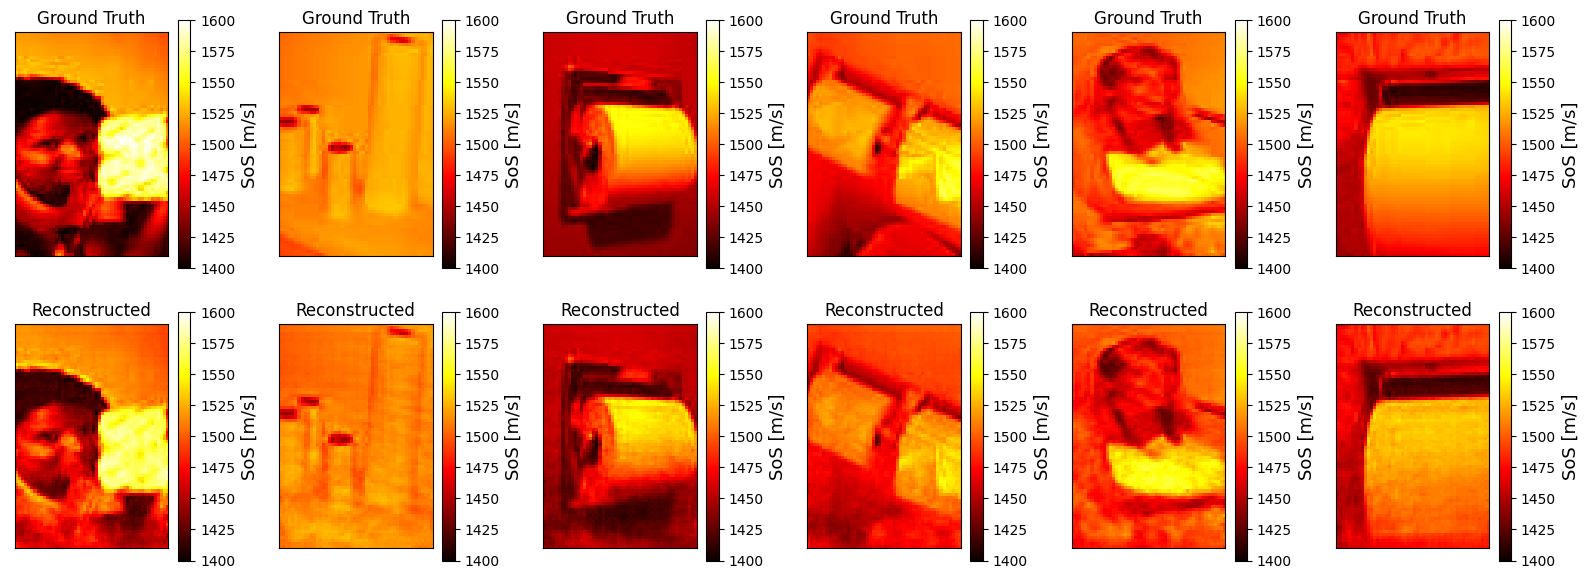

Elapsed time = 80.8251383304596
batch 21001 / 40000
running_loss = 373.03672547281815
batch_loss = 317.9956970214844
queue length = 386
RMSE in testing set is 12.505008
Elapsed time = 81.72812938690186
batch 22001 / 40000
running_loss = 372.503964240611
batch_loss = 375.9864807128906
queue length = 186
RMSE in testing set is 11.219385
Elapsed time = 81.47651243209839
batch 23001 / 40000
running_loss = 372.05275536263446
batch_loss = 393.7359313964844
queue length = 406
RMSE in testing set is 12.459548
Elapsed time = 82.37952518463135
batch 24001 / 40000
running_loss = 371.45618963515733
batch_loss = 339.98223876953125
queue length = 56
RMSE in testing set is 12.209454
Elapsed time = 84.32150769233704
batch 25001 / 40000
running_loss = 371.00093311504804
batch_loss = 335.98577880859375
queue length = 276
RMSE in testing set is 11.591546


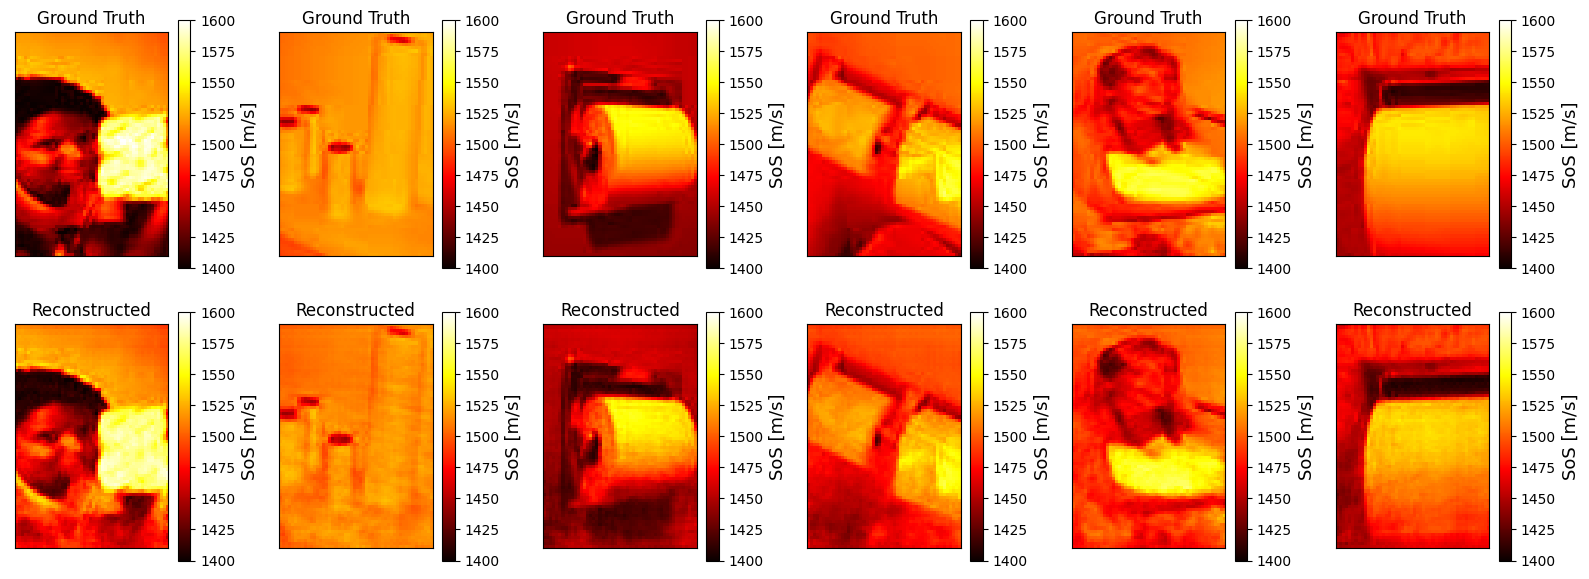

Elapsed time = 79.63778066635132
batch 26001 / 40000
running_loss = 370.5614067390418
batch_loss = 342.34228515625
queue length = 46
RMSE in testing set is 12.015125
Elapsed time = 84.28358745574951
batch 27001 / 40000
running_loss = 370.1444451979342
batch_loss = 308.06256103515625
queue length = 266
RMSE in testing set is 12.107746
Elapsed time = 82.57902193069458
batch 28001 / 40000
running_loss = 369.6815002607061
batch_loss = 399.7339172363281
queue length = 366
RMSE in testing set is 11.659758
Elapsed time = 82.31669807434082
batch 29001 / 40000
running_loss = 369.26296756629426
batch_loss = 455.925048828125
queue length = 466
RMSE in testing set is 12.55251
Elapsed time = 81.81066870689392
batch 30001 / 40000
running_loss = 368.7780351996716
batch_loss = 319.894775390625
queue length = 26
RMSE in testing set is 12.528317


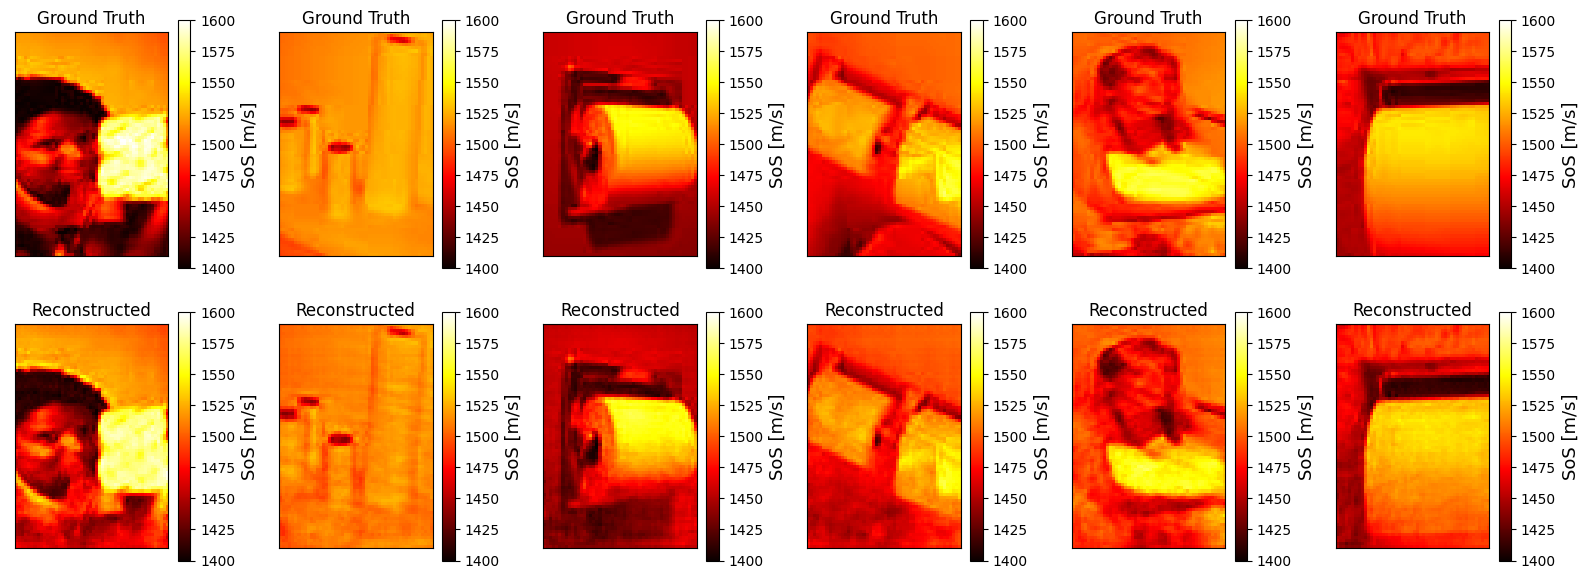

Elapsed time = 83.98952984809875
batch 31001 / 40000
running_loss = 368.31358437021044
batch_loss = 388.1169128417969
queue length = 216
RMSE in testing set is 11.727994
Elapsed time = 83.01592326164246
batch 32001 / 40000
running_loss = 367.952379851183
batch_loss = 342.1462097167969
queue length = 256
RMSE in testing set is 13.1098175
Elapsed time = 83.91586446762085
batch 33001 / 40000
running_loss = 367.5477386441319
batch_loss = 387.72515869140625
queue length = 416
RMSE in testing set is 13.76007
Elapsed time = 84.30942845344543
batch 34001 / 40000
running_loss = 367.1642670042129
batch_loss = 352.67852783203125
queue length = 426
RMSE in testing set is 11.307644
Elapsed time = 82.1792414188385
batch 35001 / 40000
running_loss = 366.7447260477415
batch_loss = 385.376220703125
queue length = 346
RMSE in testing set is 11.165492


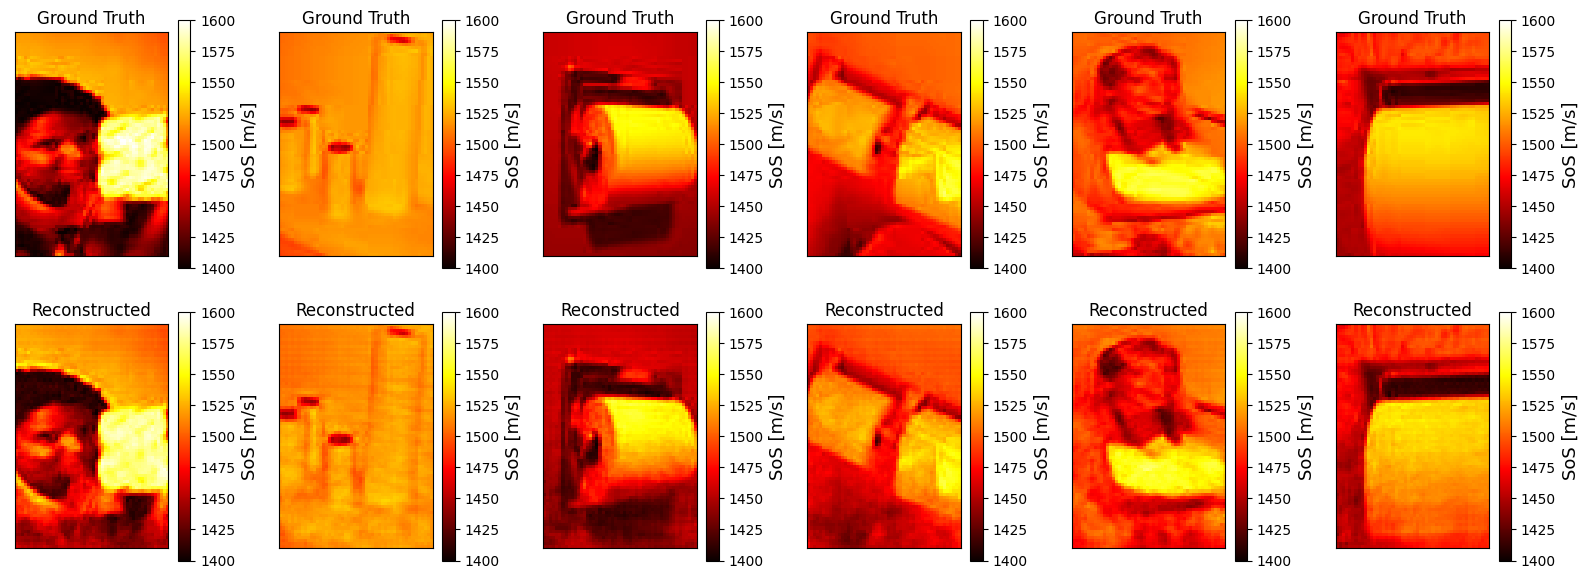

Elapsed time = 83.34429335594177
batch 36001 / 40000
running_loss = 366.44007594823427
batch_loss = 407.5673828125
queue length = 476
RMSE in testing set is 12.419326
Elapsed time = 80.1942937374115
batch 37001 / 40000
running_loss = 366.0546685900213
batch_loss = 405.59759521484375
queue length = 186
RMSE in testing set is 11.799842
Elapsed time = 81.07663059234619
batch 38001 / 40000
running_loss = 365.69695738156054
batch_loss = 343.8686828613281
queue length = 256
RMSE in testing set is 11.888164
Elapsed time = 84.77115654945374
batch 39001 / 40000
running_loss = 365.30111043210286
batch_loss = 326.74114990234375
queue length = 146
RMSE in testing set is 11.360889
Epoch 2/3 finished. Average loss: 364.894908020401
Elapsed time = 86.08104348182678
batch 1 / 40000
running_loss = 337.61366271972656
batch_loss = 330.5863952636719
queue length = 75
RMSE in testing set is 11.68334


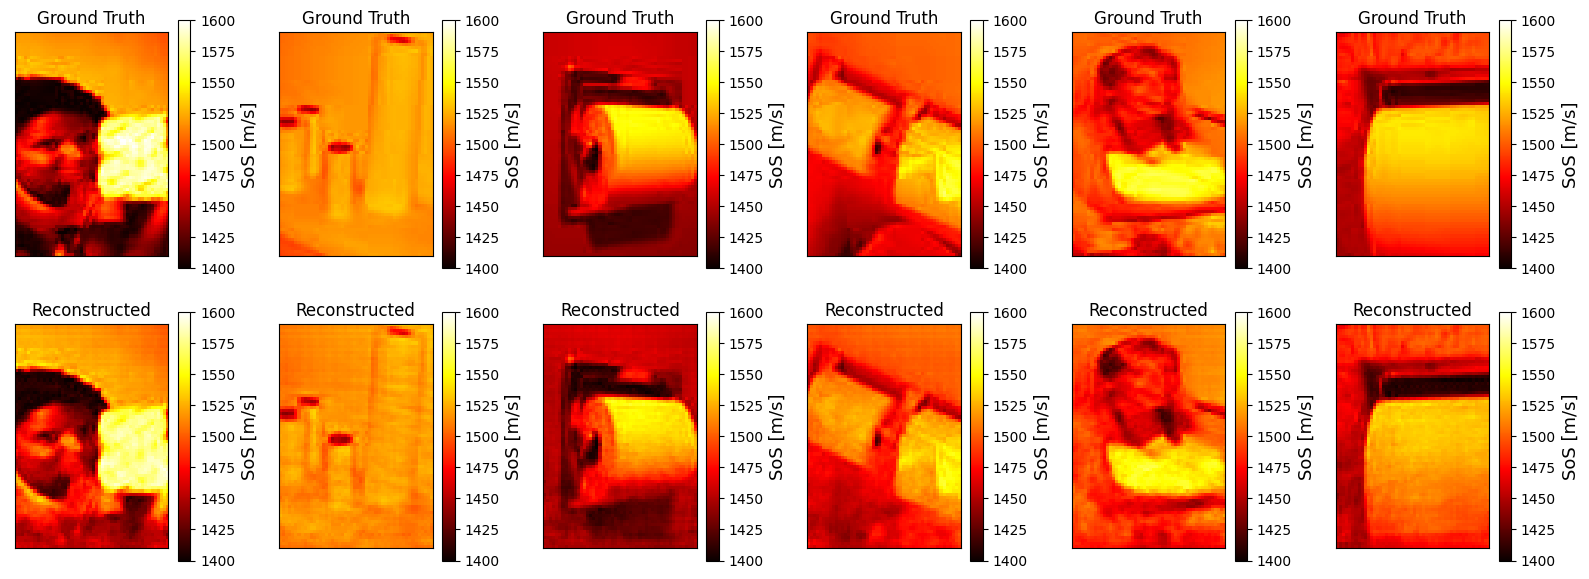

Elapsed time = 75.88140344619751
batch 1001 / 40000
running_loss = 347.98309435815867
batch_loss = 348.64398193359375
queue length = 385
RMSE in testing set is 11.567051
Elapsed time = 74.81856083869934
batch 2001 / 40000
running_loss = 346.4505510968524
batch_loss = 320.9437255859375
queue length = 305
RMSE in testing set is 12.151519
Elapsed time = 75.78920269012451
batch 3001 / 40000
running_loss = 347.20152429101626
batch_loss = 327.4598083496094
queue length = 15
RMSE in testing set is 11.122091
Elapsed time = 76.74376034736633
batch 4001 / 40000
running_loss = 347.92014201791926
batch_loss = 320.54254150390625
queue length = 385
RMSE in testing set is 12.401597
Elapsed time = 76.20589113235474
batch 5001 / 40000
running_loss = 347.7483260418977
batch_loss = 403.8935241699219
queue length = 155
RMSE in testing set is 11.199096


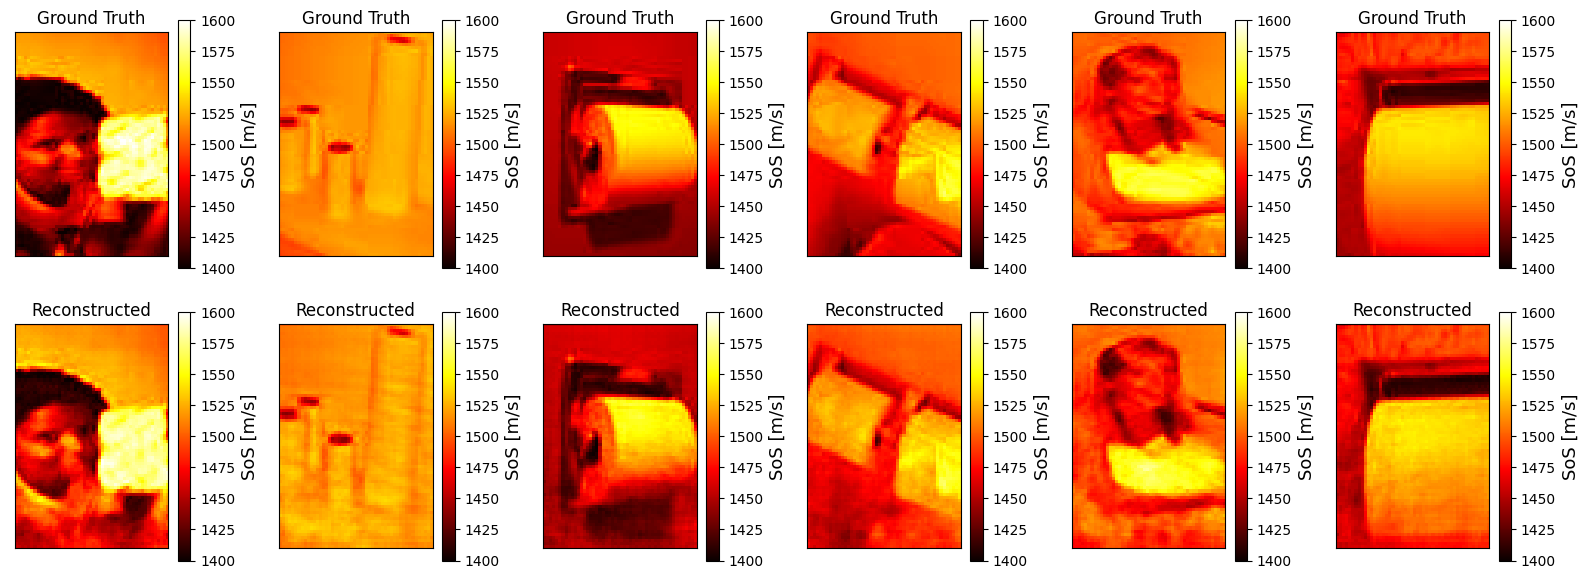

Elapsed time = 77.554128408432
batch 6001 / 40000
running_loss = 347.83001751694746
batch_loss = 384.0859680175781
queue length = 285
RMSE in testing set is 11.534796
Elapsed time = 75.46991062164307
batch 7001 / 40000
running_loss = 348.01052485108886
batch_loss = 384.6612548828125
queue length = 385
RMSE in testing set is 11.911662
Elapsed time = 76.39102506637573
batch 8001 / 40000
running_loss = 348.1233282415785
batch_loss = 381.5811462402344
queue length = 65
RMSE in testing set is 12.178952
Elapsed time = 78.26431441307068
batch 9001 / 40000
running_loss = 347.7043626332278
batch_loss = 305.6919250488281
queue length = 435
RMSE in testing set is 12.803388
Elapsed time = 74.58256793022156
batch 10001 / 40000
running_loss = 347.6771561947376
batch_loss = 334.6844482421875
queue length = 355
RMSE in testing set is 11.672144


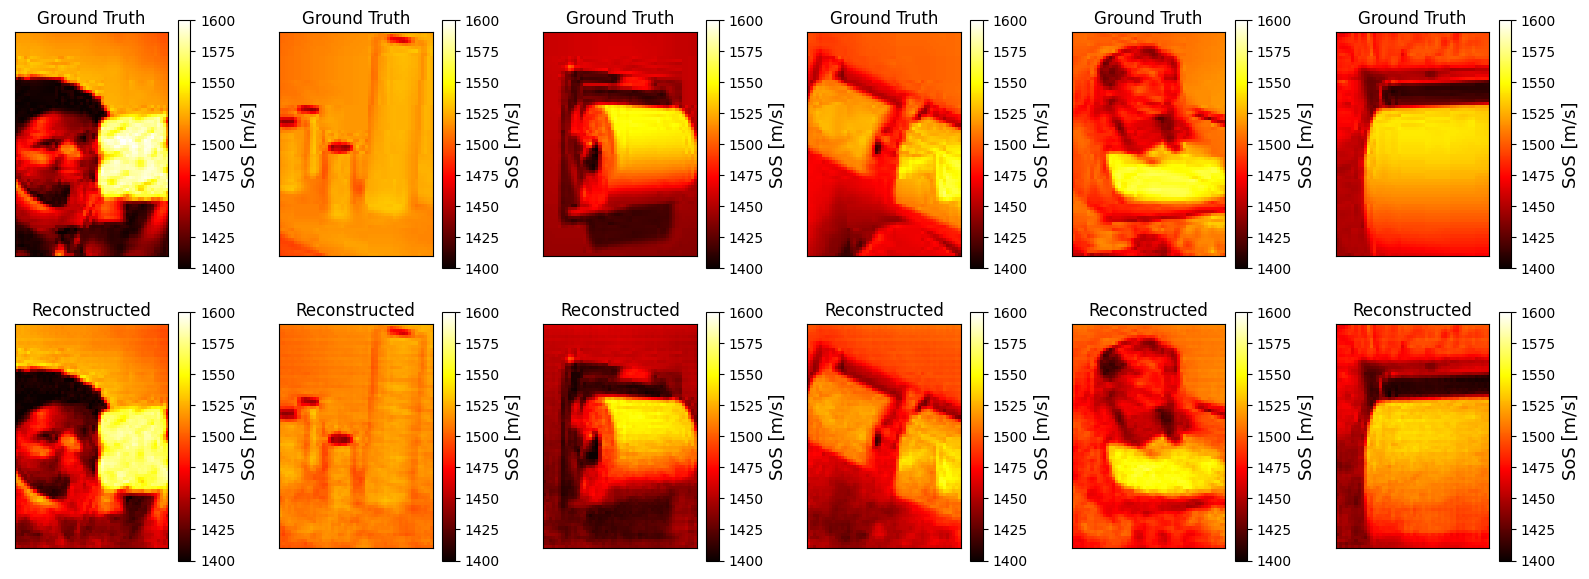

Elapsed time = 75.68192911148071
batch 11001 / 40000
running_loss = 347.35284945583845
batch_loss = 314.17401123046875
queue length = 185
RMSE in testing set is 11.471557
Elapsed time = 76.12868428230286
batch 12001 / 40000
running_loss = 346.94999817637
batch_loss = 356.5105285644531
queue length = 225
RMSE in testing set is 11.30973
Elapsed time = 76.56649994850159
batch 13001 / 40000
running_loss = 346.9356867624895
batch_loss = 327.81201171875
queue length = 55
RMSE in testing set is 11.737413
Elapsed time = 77.1831750869751
batch 14001 / 40000
running_loss = 346.90050572086244
batch_loss = 311.33984375
queue length = 95
RMSE in testing set is 11.64371
Elapsed time = 79.24754476547241
batch 15001 / 40000
running_loss = 346.7298944755771
batch_loss = 328.3112487792969
queue length = 375
RMSE in testing set is 11.495556


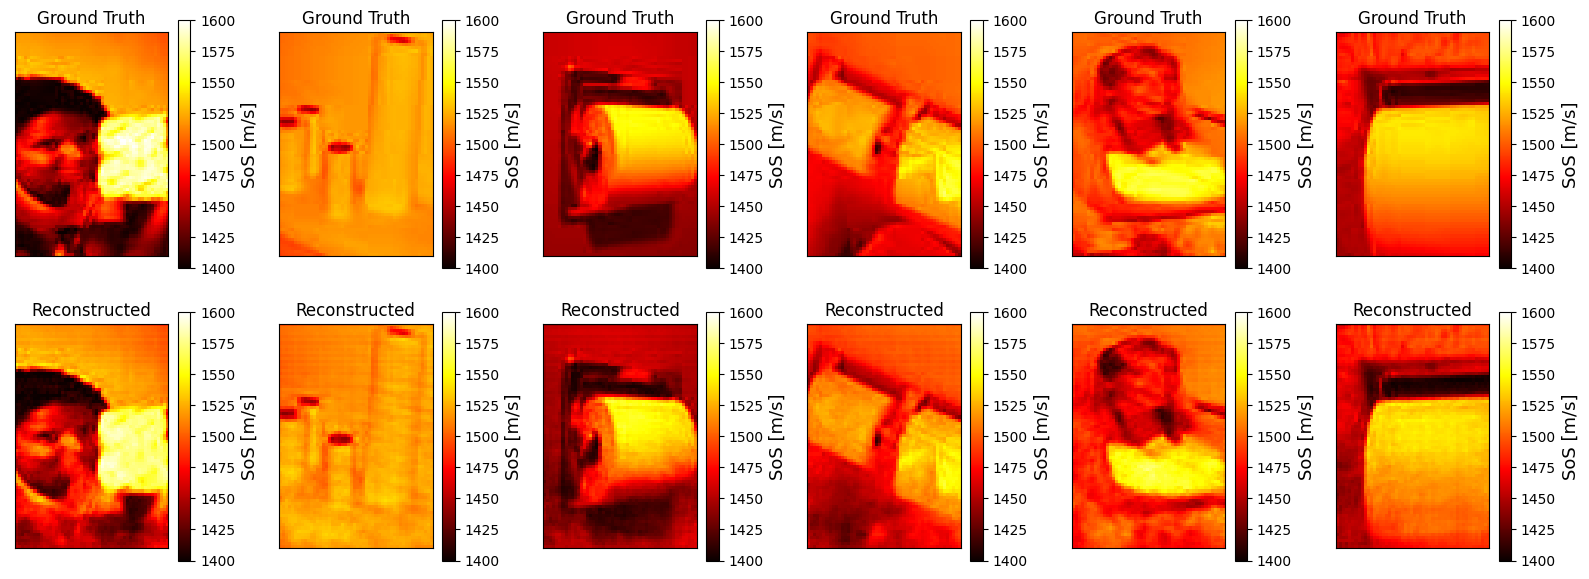

Elapsed time = 76.69971466064453
batch 16001 / 40000
running_loss = 346.5026913177906
batch_loss = 348.241943359375
queue length = 85
RMSE in testing set is 11.842366
Elapsed time = 76.68436980247498
batch 17001 / 40000
running_loss = 346.25233219848104
batch_loss = 370.527099609375
queue length = 305
RMSE in testing set is 12.474552
Elapsed time = 76.68525815010071
batch 18001 / 40000
running_loss = 346.0163263999652
batch_loss = 324.0205383300781
queue length = 405
RMSE in testing set is 11.689244
Elapsed time = 77.52190566062927
batch 19001 / 40000
running_loss = 345.69050054105503
batch_loss = 411.73822021484375
queue length = 295
RMSE in testing set is 11.778155
Elapsed time = 75.27099633216858
batch 20001 / 40000
running_loss = 345.6334780866701
batch_loss = 310.84619140625
queue length = 215
RMSE in testing set is 11.511628


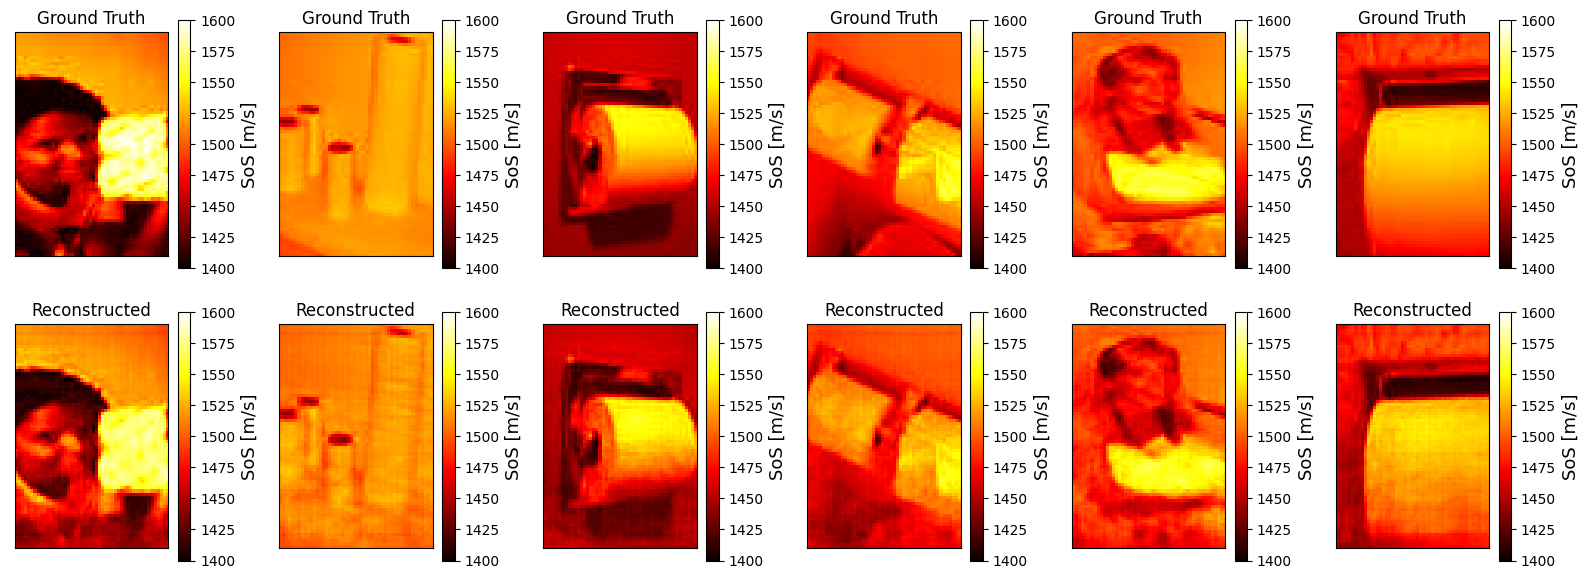

Elapsed time = 77.51573443412781
batch 21001 / 40000
running_loss = 345.4174322025309
batch_loss = 299.41241455078125
queue length = 75
RMSE in testing set is 12.607986
Elapsed time = 79.29149723052979
batch 22001 / 40000
running_loss = 345.27736689062425
batch_loss = 316.12445068359375
queue length = 445
RMSE in testing set is 11.427704
Elapsed time = 77.53942799568176
batch 23001 / 40000
running_loss = 345.05195689120507
batch_loss = 364.0240783691406
queue length = 5
RMSE in testing set is 11.314066
Elapsed time = 79.20859837532043
batch 24001 / 40000
running_loss = 344.85344553895715
batch_loss = 380.1409912109375
queue length = 135
RMSE in testing set is 12.616331
Elapsed time = 78.63654685020447
batch 25001 / 40000
running_loss = 344.6336022433391
batch_loss = 315.884033203125
queue length = 115
RMSE in testing set is 11.298678


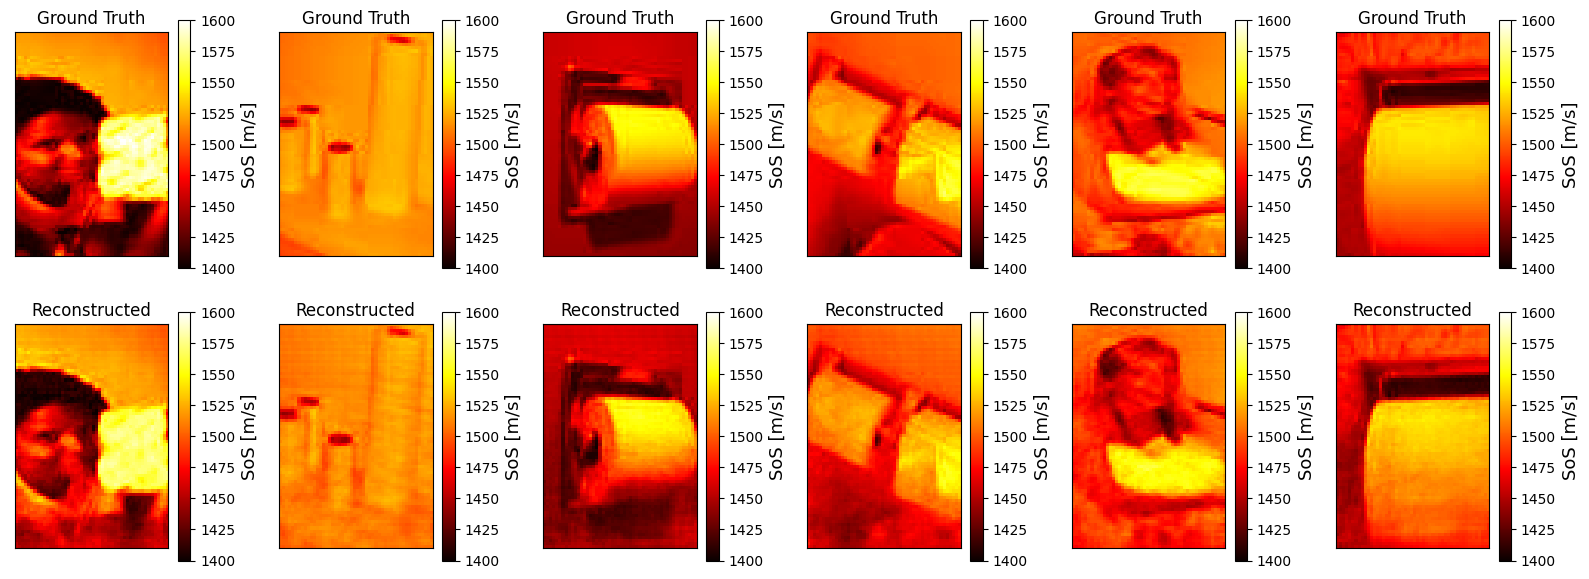

Elapsed time = 77.76798892021179
batch 26001 / 40000
running_loss = 344.47036758597727
batch_loss = 309.3948974609375
queue length = 65
RMSE in testing set is 11.330435
Elapsed time = 79.71323275566101
batch 27001 / 40000
running_loss = 344.4981515521465
batch_loss = 268.25518798828125
queue length = 285
RMSE in testing set is 11.944551
Elapsed time = 78.82089948654175
batch 28001 / 40000
running_loss = 344.3070558703684
batch_loss = 322.3885803222656
queue length = 25
RMSE in testing set is 10.677381
Elapsed time = 77.57125639915466
batch 29001 / 40000
running_loss = 344.18341250650127
batch_loss = 357.1576232910156
queue length = 185
RMSE in testing set is 11.528101
Elapsed time = 79.77997541427612
batch 30001 / 40000
running_loss = 344.0643282447145
batch_loss = 333.2109680175781
queue length = 435
RMSE in testing set is 11.550948


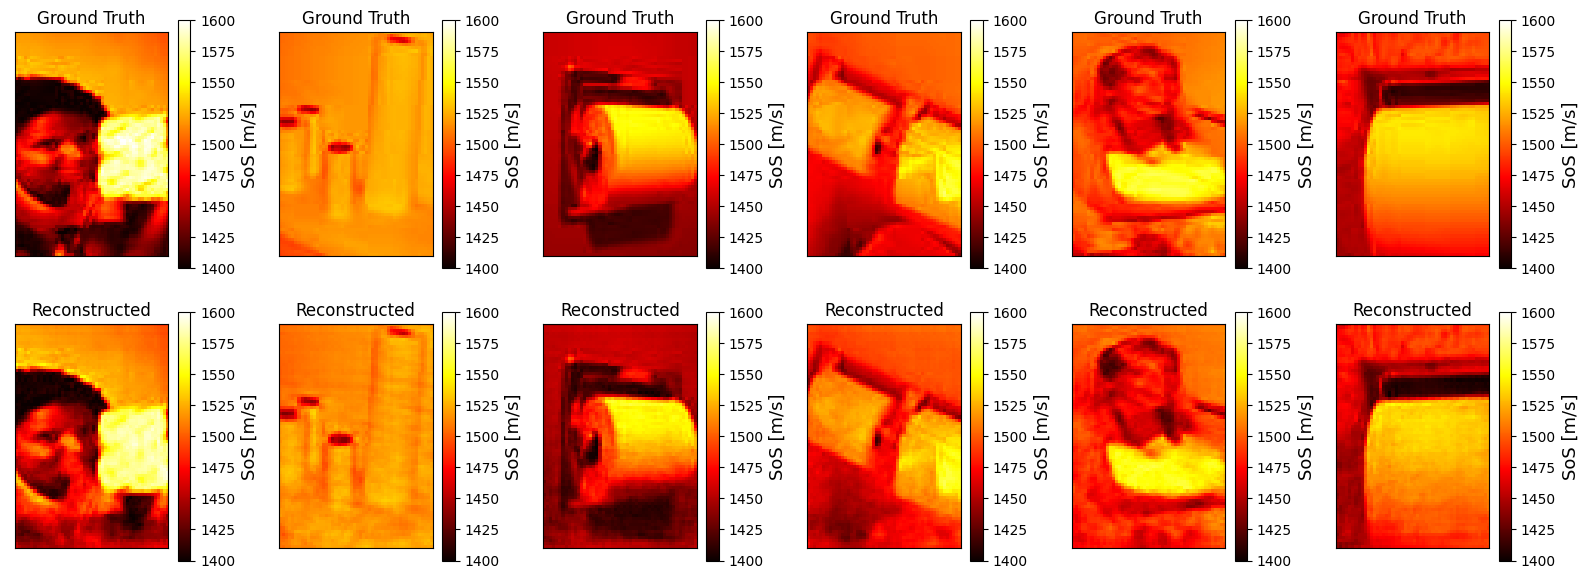

Elapsed time = 77.37783527374268
batch 31001 / 40000
running_loss = 343.87038556883914
batch_loss = 315.40716552734375
queue length = 325
RMSE in testing set is 11.667471
Elapsed time = 78.93538498878479
batch 32001 / 40000
running_loss = 343.6447816439535
batch_loss = 316.5570373535156
queue length = 125
RMSE in testing set is 11.17681
Elapsed time = 77.48846626281738
batch 33001 / 40000
running_loss = 343.56924311836286
batch_loss = 301.50128173828125
queue length = 105
RMSE in testing set is 11.196529
Elapsed time = 79.37491154670715
batch 34001 / 40000
running_loss = 343.3419635122674
batch_loss = 317.753662109375
queue length = 295
RMSE in testing set is 11.026752
Elapsed time = 77.51449871063232
batch 35001 / 40000
running_loss = 343.23522210343214
batch_loss = 320.4919738769531
queue length = 215
RMSE in testing set is 11.762478


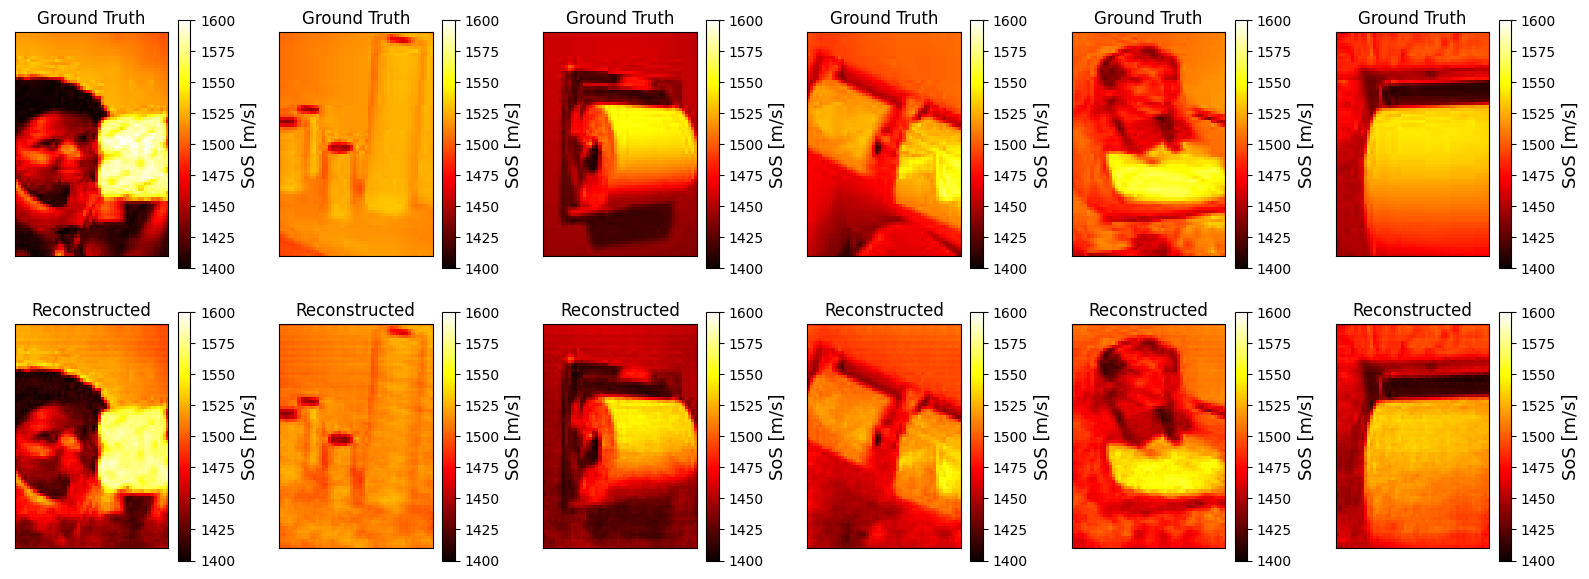

Elapsed time = 80.34618806838989
batch 36001 / 40000
running_loss = 343.0215775031168
batch_loss = 333.7187805175781
queue length = 165
RMSE in testing set is 11.114091
Elapsed time = 78.97026538848877
batch 37001 / 40000
running_loss = 342.88188711559894
batch_loss = 365.9583740234375
queue length = 175
RMSE in testing set is 11.27859
Elapsed time = 76.78489208221436
batch 38001 / 40000
running_loss = 342.8081345733583
batch_loss = 345.6504211425781
queue length = 245
RMSE in testing set is 12.102563
Elapsed time = 81.97101521492004
batch 39001 / 40000
running_loss = 342.66614001531195
batch_loss = 413.9867248535156
queue length = 225
RMSE in testing set is 10.9924555
Epoch 3/3 finished. Average loss: 342.5400463973999


In [6]:
model = build_net().to(f"cuda:{GPU_BASE}")
model = nn.DataParallel(model, device_ids=GPU_LIST_TO_PARALLEL)
model.train()
set_stateless_batchnorm(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAM_LEARNING_RATE, weight_decay=PARAM_WEIGHTDECAY)

manager = mp.Manager()
shared_queue_time_lag = manager.list()
shared_lock_1, shared_lock_2 = mp.Lock(), mp.Lock()
idx_list_init = list(range(PARAM_NUMBER_OF_TRAINING_DATA))
random.shuffle(idx_list_init)
img_idx_tobe_loaded = manager.list(idx_list_init)


processes = [
    mp.Process(
        target=preparing_training_data,
        args=(
            shared_lock_1,
            shared_lock_2,
            img_idx_tobe_loaded,
            shared_queue_time_lag,
            PARAM_NUMBER_OF_TRAINING_DATA,
            4000,
            data_parent_dir,  # <--- Pass the data dir to the worker
        ),
    )
    for _ in range(3)
]
for p in processes:
    p.start()
    sleep(1)

LEN_TRAINING_DATA = PARAM_NUMBER_OF_TRAINING_DATA
last_time_stamp = time.time()
for epoch_i in range(EPOCH_NUM):
    running_loss = 0.0
    for batch_i in range(LEN_TRAINING_DATA // BATCH_SIZE):
        batch_data_np, batch_label_np = [], []
        for _ in range(BATCH_SIZE):
            while len(shared_queue_time_lag) == 0:
                sleep(1)
            time_lag_np, sos_np = shared_queue_time_lag.pop()
            batch_data_np.append(time_lag_np * PARAM_SCALING_INPUT)
            batch_label_np.append(sos_np)

        batch_data = torch.from_numpy(np.stack(batch_data_np)).to(f"cuda:{GPU_BASE}", dtype=torch.float)
        batch_label = torch.from_numpy(np.stack(batch_label_np)).unsqueeze(1).to(f"cuda:{GPU_BASE}", dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss_MSE = criterion(
            outputs[:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL] * PARAM_SCALING_OUTPUT + PARAM_BASE_OUTPUT,
            batch_label[:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL],
        )
        
        loss_SSIM = -SSIM_LOSS((outputs[:,:,:,STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL]-1400)/200,
                                       (batch_label[:,:,:,STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL]-1400)/200)
        loss = loss_MSE + 5000*loss_SSIM
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_i % 1000 == 1:
            print("Elapsed time =", time.time() - last_time_stamp)
            last_time_stamp = time.time()
            print(f"batch {batch_i} / {LEN_TRAINING_DATA // BATCH_SIZE}")
            print("running_loss =", running_loss / (batch_i + 1))
            print("batch_loss =", loss.item())
            print("queue length =", len(shared_queue_time_lag))

            from datetime import datetime
            current_date = datetime.now().strftime("%Y_%m_%d")
            ckpt_name = (
                f"./pre_trained_model_d{current_date}_parametric_3_input_beamforming_SoS_"
                f"{PARAM_SOS_BEAMFORMING}_output_base_{PARAM_BASE_OUTPUT}_NumberOfTraningData_"
                f"{PARAM_NUMBER_OF_TRAINING_DATA}_learning_rate_{PARAM_LEARNING_RATE}_"
                f"PARAM_WEIGHTDECAY_{PARAM_WEIGHTDECAY}_no_batch_norm.pt"
            )
            torch.save(model.module.state_dict(), ckpt_name)
            model.eval()
            eval_testingdata(model, test_data, test_label, criterion)
            if batch_i % 5000 == 1:
                visualize_test_data()
            model.train()

    print(f"Epoch {epoch_i + 1}/{EPOCH_NUM} finished. "
          f"Average loss: {running_loss / (LEN_TRAINING_DATA / BATCH_SIZE)}")
